
# *H2 energy with various variational forms*

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule using VQE with different variation form configurations. The results are compared to the same energy as computed with the UCCSD ansatz and the ParityMapper (as in https://qiskit-community.github.io/qiskit-nature/getting_started.html)

This notebook needs a chemistry driver e.g. PySCF.


In [ ]:
%pip install qiskit
%pip install qiskit_aer
%pip install qiskit_ibm_runtime
%pip install matplotlib
%pip install pylatexenc
%pip install qiskit-transpiler-service
%pip install qiskit-nature
%pip install qiskit-nature-pyscf

## Precise value

In [8]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver


driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.74279')
problem = driver.run()

mapper = ParityMapper(num_particles=problem.num_particles)

optimizer = L_BFGS_B()

estimator = Estimator()

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

vqe = VQE(estimator, ansatz, optimizer)
vqe.initial_point = [0] * ansatz.num_parameters

algorithm = GroundStateEigensolver(mapper, vqe)

electronic_structure_result = algorithm.solve(problem)
electronic_structure_result.formatting_precision = 6
print(electronic_structure_result) # we're going to calculate the total ground state energy

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.849672
  - computed part:      -1.849672
~ Nuclear repulsion energy (Hartree): 0.712418
> Total ground state energy (Hartree): -1.137253
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.40367]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.40367]
    - computed part:      [0.0  0.0  1.40367]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


## Trying different ansatze

In [11]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.74279')
problem = driver.run()

mapper = JordanWignerMapper()

optimizer = SLSQP(maxiter=10000, ftol=1e-9)

estimator = Estimator()

In [19]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
import numpy as np

var_forms = [['ry', 'rz'], 'ry']
entanglements = ['full', 'linear']
entanglement_blocks = ['cx', 'cz', ['cx', 'cz']]
depths = list(range(1, 11))

reference_circuit = QuantumCircuit(4)
reference_circuit.x(0)
reference_circuit.x(2)

results = np.zeros((len(depths), len(entanglements), len(var_forms), len(entanglement_blocks)))

for i, d in enumerate(depths):
    print(f'Depth: {d} done.')
    for j, e in enumerate(entanglements):
        for k, vf in enumerate(var_forms):
            for l, eb in enumerate(entanglement_blocks):
                optimizer = SLSQP(maxiter=10000, ftol=1e-9)
                variational_form = TwoLocal(4, rotation_blocks=vf, entanglement_blocks=eb,entanglement=e, reps=d)

                ansatz = reference_circuit.compose(variational_form)

                vqe = VQE(estimator, ansatz, optimizer)
                vqe.initial_point = [0] * ansatz.num_parameters

                algorithm = GroundStateEigensolver(mapper, vqe)

                electronic_structure_result = algorithm.solve(problem)
                
                results[i, j, k, l] = electronic_structure_result.total_energies[0]

Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10


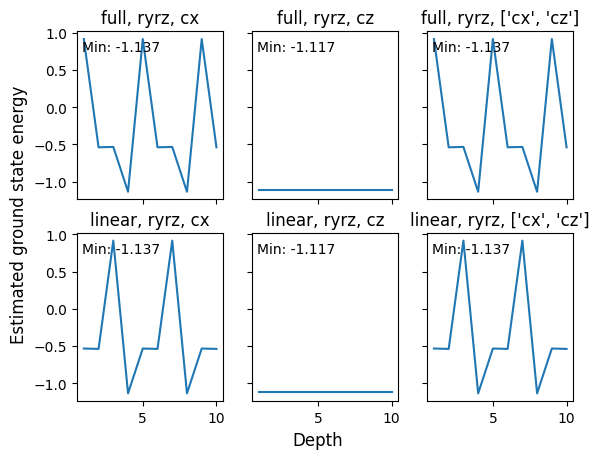

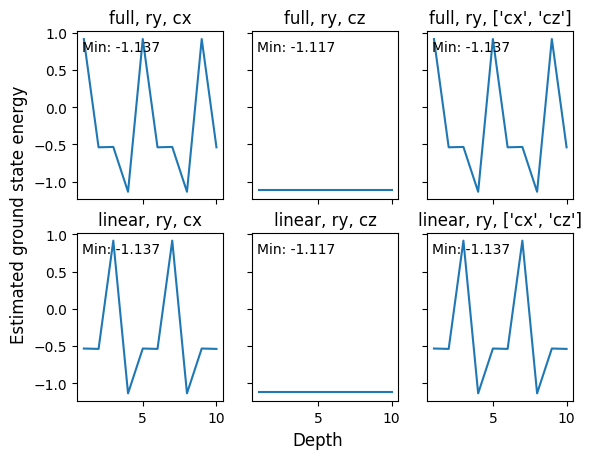

In [20]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(2, 3, sharey=True, sharex=True)
fig2, axs2 = plt.subplots(2, 3, sharey=True, sharex=True)

fig1.supxlabel('Depth')
fig1.supylabel('Estimated ground state energy')
fig2.supxlabel('Depth')
fig2.supylabel('Estimated ground state energy')

for j, e in enumerate(entanglements):
    for l, eb in enumerate(entanglement_blocks):
        axs1[j, l].plot(depths, results[:, j, 0, l])
        axs1[j, l].set_title(f'{e}, ryrz, {eb}')
        axs1[j, l].text(0.90, 0.75, f'Min: {np.min(results[:, j, 0, l]):.3f}')
        
for j, e in enumerate(entanglements):
    for l, eb in enumerate(entanglement_blocks):
        axs2[j, l].plot(depths, results[:, j, 1, l])
        axs2[j, l].set_title(f'{e}, ry, {eb}')
        axs2[j, l].text(0.90, 0.75, f'Min: {np.min(results[:, j, 1, l]):.3f}')

In [8]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
